In [2]:
import numpy as np
import pandas as pd

from smartem.segmentation import segmenter, utils
from skimage import measure
from smartem.offline.train_mb_error_detector.NNtools import UNet

import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyvoi
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
from tqdm import tqdm
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Set Variables and Models

In [3]:
checkpoint_folder = "/storage2/projects/smartEM/HybridGT_Models"
checkpoint_path = f"{checkpoint_folder}/unet_48_1.18e-01.pth"
data_path = "/storage2/projects/smartEM/em-vis/smartem-256-hybridgt-test.hdf5"
device = torch.device("cuda:1")
model = UNet.UNet(1,2)

# Define segmentation processing for testing different segmentations

In [4]:
def get_segmentation_output(data_path, Iseg):

    data_dwts = []
    data_hdt_vois = []
    data_gt_vois = []

    with h5py.File(data_path, "r") as f:
        for reg in tqdm(f.keys()):
            group = f[reg]

            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

            # 1200ns
            im = group[f"{slowest_dwt}/im"][()]
            hdt_labels = Iseg.get_labels(im)


            # all dwts
            for dwt in group.keys():
                im = group[f"{dwt}/im"][()]

                labels = Iseg.get_labels(im)

                voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
                voi_hdt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
                data_gt_vois.append(voi_gt.item())
                data_hdt_vois.append(voi_hdt.item())
                data_dwts.append(int(dwt))

    return data_dwts, data_hdt_vois, data_gt_vois
    

In [5]:

Iseg_cc = segmenter.Segmenter(checkpoint_path, segmenter_function = measure.label, device=device)
Iseg_cc.set_model(model_class=model)

data_dwts_cc, data_hdt_vois_cc, data_gt_vois_cc = get_segmentation_output(data_path, Iseg_cc)



# data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
# df = pd.DataFrame(data=data)

100%|██████████| 18/18 [02:39<00:00,  8.87s/it]


In [6]:
Iseg_watershed = segmenter.Segmenter(checkpoint_path, segmenter_function = watershed, device=device)
Iseg_watershed.set_model(model_class=model)

data_dwts_watershed, data_hdt_vois_watershed, data_gt_vois_watershed = get_segmentation_output(data_path, Iseg_watershed)

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [05:22<00:00, 17.94s/it]


# Compare the two segmentations using a box plot

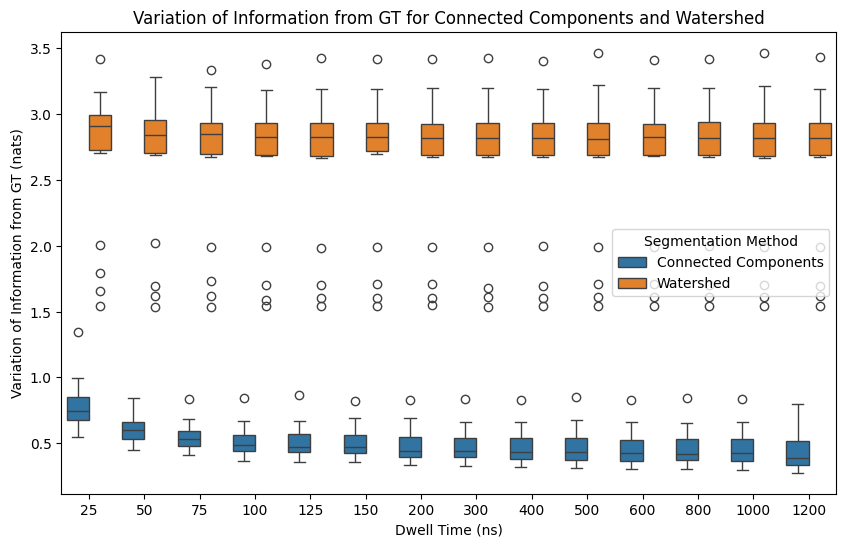

In [7]:
methods = ['Connected Components'] * len(data_dwts_cc) + ['Watershed'] * len(data_dwts_watershed)

data = {
    "Dwell Time (ns)": data_dwts_cc + data_dwts_watershed, 
    "Variation of Information from GT (nats)": data_gt_vois_cc + data_gt_vois_watershed, 
    "Segmentation Method": methods
}

df = pd.DataFrame(data=data)

plt.figure(figsize=(10, 6))
sns.boxplot(x="Dwell Time (ns)", y="Variation of Information from GT (nats)", hue="Segmentation Method", data=df)
plt.title("Variation of Information from GT for Connected Components and Watershed")
plt.show()

# Comparing based on Auto-GT

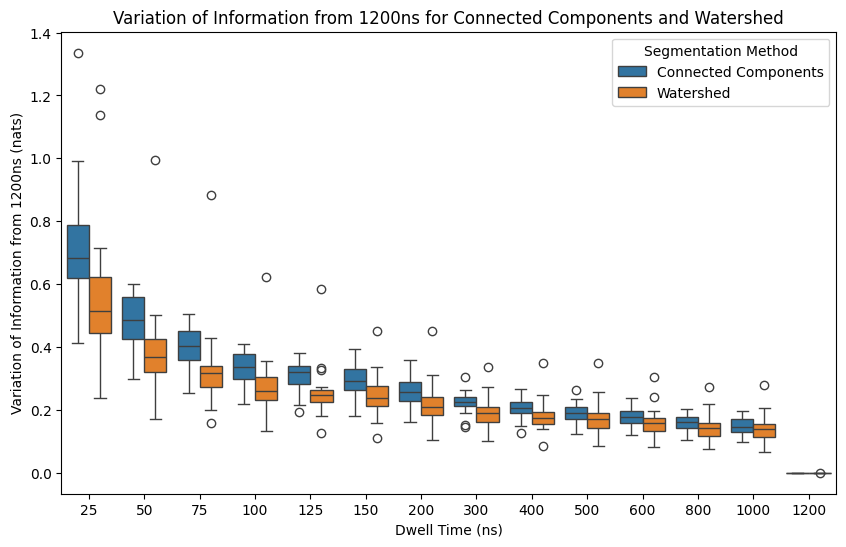

In [7]:
methods = ['Connected Components'] * len(data_dwts_cc) + ['Watershed'] * len(data_dwts_watershed)

data = {
    "Dwell Time (ns)": data_dwts_cc + data_dwts_watershed, 
    "Variation of Information from 1200ns (nats)": data_hdt_vois_cc + data_hdt_vois_watershed,
    "Segmentation Method": methods
}

df = pd.DataFrame(data=data)

plt.figure(figsize=(10, 6))
sns.boxplot(x="Dwell Time (ns)", y="Variation of Information from 1200ns (nats)", hue="Segmentation Method", data=df)
plt.title("Variation of Information from 1200ns for Connected Components and Watershed")
plt.show()


